This notebook aims to build a graph purely with KNN.

In [1]:
import numpy as np
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-trainval', dataroot='/media/HDD2/Datasets/mini_nusc', verbose=True)

# nusc = NuScenes(version='v1.0-trainval', dataroot='/media/HDD2/Datasets/nuscenes2', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.530 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [3]:
#How many samples do I have in one scene?
#Get set of scenes
scenes = nusc.scene
#Get first scenes
for scene in scenes:
    current_token = scene['first_sample_token']
    count_samples = 0
    while(current_token != scene['last_sample_token']):
        temp_sample = nusc.get('sample', current_token)
        temp_token = temp_sample['next']
        current_token = temp_token
        count_samples += 1

    print("Scene:",scene['name'],"has Sample number:",count_samples)

Scene: scene-0061 has Sample number: 38
Scene: scene-0103 has Sample number: 39
Scene: scene-0553 has Sample number: 40
Scene: scene-0655 has Sample number: 40
Scene: scene-0757 has Sample number: 40
Scene: scene-0796 has Sample number: 39
Scene: scene-0916 has Sample number: 40
Scene: scene-1077 has Sample number: 40
Scene: scene-1094 has Sample number: 39
Scene: scene-1100 has Sample number: 39


In [4]:
#Get set of scenes
scenes = nusc.scene
#Get first scenes
scene_0 = scenes[0]
# Get token of first frame
first_sample_token = scene_0['first_sample_token']

NUMBER_OF_SKIPPED_FRAMES = 10
for i in range(NUMBER_OF_SKIPPED_FRAMES):
    temp_sample = nusc.get('sample', first_sample_token)
    temp_token = temp_sample['next']
    first_sample_token = temp_token

sample_0 = nusc.get('sample', first_sample_token)
# Get tokens for 2 following frames
second_sample_token = sample_0['next']
sample_1 = nusc.get('sample', second_sample_token)
third_sample_token = sample_1['next']
sample_2 = nusc.get('sample', third_sample_token)

# Get LIDAR pointcloud
sensor = 'LIDAR_TOP'
lidar_top_data_0 = nusc.get('sample_data', sample_0['data'][sensor])
# Get LIDAR KF pointcloud
lidar_top_data_1 = nusc.get('sample_data', sample_1['data'][sensor])
# Get LIDAR KF pointcloud
lidar_top_data_2 = nusc.get('sample_data', sample_2['data'][sensor])

/home/maximilian/anaconda3/envs/nuscenes/lib/python3.9/site-packages/nuscenes/nuscenes.py:1028: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(sample_token)


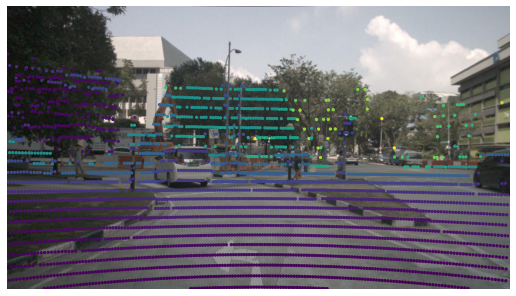

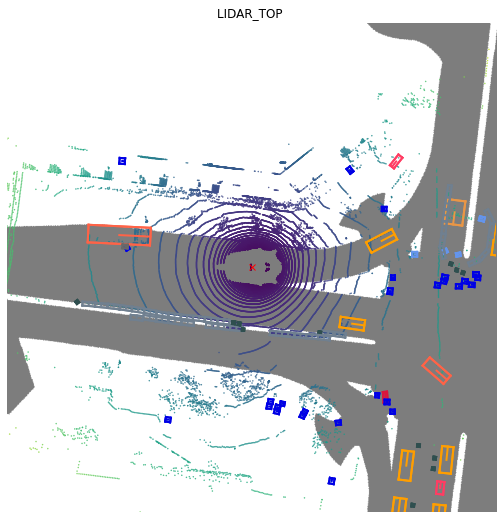

In [5]:
nusc.render_pointcloud_in_image(sample_0['token'])
nusc.render_sample_data(lidar_top_data_0['token'])

In [6]:
#Filter out car/vehicle object
pcl0_path, boxes0, _= nusc.get_sample_data(lidar_top_data_0['token'], selected_anntokens=None, use_flat_vehicle_coordinates =False)
pcl1_path, boxes1, _= nusc.get_sample_data(lidar_top_data_1['token'], selected_anntokens=None, use_flat_vehicle_coordinates =False)
pcl2_path, boxes2, _= nusc.get_sample_data(lidar_top_data_2['token'], selected_anntokens=None, use_flat_vehicle_coordinates =False)


In [7]:
# Get point clouds
import os.path as osp
from nuscenes.utils.data_classes import LidarPointCloud, Box

#Load Pointclouds
pc0 = LidarPointCloud.from_file(pcl0_path)
pc1 = LidarPointCloud.from_file(pcl1_path)
pc2 = LidarPointCloud.from_file(pcl2_path)

In [8]:
from utility import get_box_centers, filter_boxes

car_boxes_0 = filter_boxes(nusc, boxes = boxes0, categoryQuery= 'vehicle.car')
car_boxes_1 = filter_boxes(nusc, boxes = boxes1, categoryQuery= 'vehicle.car')
car_boxes_2 = filter_boxes(nusc, boxes = boxes2, categoryQuery= 'vehicle.car')

centers0 = get_box_centers(car_boxes_0)
centers1 = get_box_centers(car_boxes_1)
centers2 = get_box_centers(car_boxes_2)

# Special Shift parameter in meter
SPATIAL_SHIFT_TIMEFRAMES = 20
# Boxes 0 can stay at the current frame
# centers0
# Boxes 1 must be translated up by l meters
centers1 += np.array([0,0,SPATIAL_SHIFT_TIMEFRAMES])

# Boxes 2 must be translated up by 2*l meters
centers2 += np.array([0,0,2*SPATIAL_SHIFT_TIMEFRAMES])

# Add all centroids into one array
centers = np.empty((0,3))
centers = np.append(centers, centers0, axis=0)
centers = np.append(centers, centers1, axis=0)
centers = np.append(centers, centers2, axis=0)

In [9]:
a = range(len(centers0))
print(a[-1])
np.shape(centers0)

center = centers1[0]
center = np.expand_dims(center,axis=0)
temp = np.append(centers2,center,axis=0)
np.argwhere(temp == center)[0][0]

10


11

In [10]:
# Build KNN Graph
from sklearn.neighbors import NearestNeighbors
from graph.graph_generation import Graph

# Add temporal edges / Make connections#####################
temporal_pointpairs = []

TEMPORAL_KNN_PARAM = 3
''' 
Defines the number of searched neighbors
'''

# connect frame-0-nodes with frame-1-nodes
for i in range(len(centers0)):
    center = centers0[i]
    center = np.expand_dims(center,axis=0)
    temp = np.append(centers1,center,axis=0)
    #Find nearest_neigbor
    nearest_neigbor = NearestNeighbors(n_neighbors=TEMPORAL_KNN_PARAM, algorithm='ball_tree').fit(temp)
    temporal_distances, temporal_indices = nearest_neigbor.kneighbors(temp)
    #Add indices into a list
    for index in temporal_indices[-1]:
        #adapt the index to the global indexing
        # temporal_pointpairs.append([i, index + len(centers0)])

        # find global indices and append them
        reference_node_global_index = np.argwhere(centers == center)[0,0]
        neighbor_node_global_index = np.argwhere(centers == temp[index])[0,0] 
        temporal_pointpairs.append([reference_node_global_index ,\
             neighbor_node_global_index ])

# connect frame-0-nodes with frame-2-nodes
for i in range(len(centers0)):
    center = centers0[i]
    center = np.expand_dims(center,axis=0)
    temp = np.append(centers2,center,axis=0)
    #Find nearest_neigbor
    nearest_neigbor = NearestNeighbors(n_neighbors=TEMPORAL_KNN_PARAM, algorithm='ball_tree').fit(temp)
    temporal_distances, temporal_indices = nearest_neigbor.kneighbors(temp)
    #Add indices into a list (The last entry belongs to center!)
    for index in temporal_indices[-1]:
        #adapt the index to the global indexing
        # temporal_pointpairs.append([i, index + len(centers0)])

        # find global indices and append them
        reference_node_global_index = np.argwhere(centers == center)[0,0]
        neighbor_node_global_index = np.argwhere(centers == temp[index])[0,0] 
        temporal_pointpairs.append([reference_node_global_index ,\
             neighbor_node_global_index ])

# connect frame-1-nodes with frame-2-nodes
for i in range(len(centers1)):
    center = centers1[i]
    center = np.expand_dims(center,axis=0)
    temp = np.append(centers2,center,axis=0)
    nearest_neigbor = NearestNeighbors(n_neighbors=TEMPORAL_KNN_PARAM, algorithm='ball_tree').fit(temp)
    temporal_distances, temporal_indices = nearest_neigbor.kneighbors(temp)

    # Test if the last input is the appended center point
    # assert (temporal_distances[-1] == temporal_distances[np.argwhere(temp == center)[0,0]]).all()

    for index in temporal_indices[-1]:
        #adapt the index to the global indexing
        # temporal_pointpairs.append([i + len(centers0) , index + len(centers0) + len(centers1) ])
        
        # find global indices and append them
        reference_node_global_index = np.argwhere(centers == center)[0,0]
        neighbor_node_global_index = np.argwhere(centers == temp[index])[0,0] 
        temporal_pointpairs.append([reference_node_global_index ,\
             neighbor_node_global_index ])


    
# #
# nbrs_temporal = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(centers)
# spatial_temporal_distances, spatial_temporal_indices = nbrs_temporal.kneighbors(centers)
# # Make a list of tuple pairs

# for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_temporal_indices):
#     for neigbor_index in neigborhood_indices:
#         spatial_temporal_pointpairs.append( \
#             ( curr_node_idx , neigbor_index ) )

In [11]:
#Build graph in a more organised manner
from graph.graph_generation import SpatioTemporalGraph, Timeframe

SPATIAL_NEIGHBOR_NUMS = 5

nbrs_0 = NearestNeighbors(n_neighbors=SPATIAL_NEIGHBOR_NUMS, algorithm='ball_tree').fit(centers0)
# Frame t0
#Compute K nearest neighbors
spatial_distances_0, spatial_indices_0 = nbrs_0.kneighbors(centers0)
# Make a list of tuple pairs
spatial_pairs = [] 
for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_indices_0):
    for neigbor_index in neigborhood_indices:
        spatial_pairs.append( \
            ( (Timeframe.t0,curr_node_idx) , ((Timeframe.t0,neigbor_index)) ) )

#Frame t1
nbrs_1 = NearestNeighbors(n_neighbors=SPATIAL_NEIGHBOR_NUMS, algorithm='ball_tree').fit(centers1)
spatial_distances_1, spatial_indices_1 = nbrs_1.kneighbors(centers1)
# Make a list of tuple pairs
for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_indices_1):
    for neigbor_index in neigborhood_indices:
        spatial_pairs.append( \
            ( (Timeframe.t1,curr_node_idx) , ((Timeframe.t1,neigbor_index)) ) )

#Frame t2
nbrs_2 = NearestNeighbors(n_neighbors=SPATIAL_NEIGHBOR_NUMS, algorithm='ball_tree').fit(centers2)
spatial_distances_2, spatial_indices_2 = nbrs_2.kneighbors(centers2)
# Make a list of tuple pairs
for curr_node_idx ,neigborhood_indices,  in enumerate(spatial_indices_2):
    for neigbor_index in neigborhood_indices:
        spatial_pairs.append( \
            ( (Timeframe.t2,curr_node_idx) , ((Timeframe.t2,neigbor_index)) ) )

testgraph = SpatioTemporalGraph(spatial_pairs)

# Get all spatial Edges
spatial_pointpairs0 = []
for reference_node in testgraph._graph:
    if(reference_node[0]== Timeframe.t0):
        for neighbor_node in testgraph._graph[reference_node]:
            # print(neighbor_index[0])
            timestep, idx = neighbor_node[0],neighbor_node[1]
            if timestep == Timeframe.t0:
                spatial_pointpairs0.append([reference_node[1],idx])

print(np.shape(spatial_pointpairs0))
testarray = testgraph.get_spatial_pointpairs(Timeframe.t0)
assert spatial_pointpairs0 == testarray

spatial_pointpairs1 = testgraph.get_spatial_pointpairs(Timeframe.t1)
spatial_pointpairs2 = testgraph.get_spatial_pointpairs(Timeframe.t2)

(63, 2)


Generate Flow labels

In [12]:
print(car_boxes_0[0].center == centers0[0])
print(car_boxes_1[0].center == centers1[0])
print(car_boxes_2[0].center == centers2[0])

[ True  True  True]
[ True  True False]
[ True  True False]


In [13]:
print(car_boxes_0[0].center)
print(centers0[0])
print(car_boxes_2[0].center)
print(centers2[0])

[40.13965242 22.96978985 -0.63037307]
[40.13965242 22.96978985 -0.63037307]
[41.24195625 14.39119526 -1.47352911]
[41.24195625 14.39119526 38.52647089]


In [15]:
# Generate  Flow Labels for TrackingGNN
from groundtruth_generation.nuscenes_create_gt import generate_flow_labels
from utils.nuscenes_helper_functions import is_valid_box

car_boxes = [] 
for list in [car_boxes_0, car_boxes_1, car_boxes_2]:
    for box in list:
        car_boxes.append(box)

if len(car_boxes)== len(centers):
    print('length', len(car_boxes))
    # for box, center in zip(car_boxes, centers):
    for i in range(len(car_boxes)):
        box, center = car_boxes[i], centers[i]
        if not is_valid_box(box, center, num_frames = 3, spatial_shift_timeframes=SPATIAL_SHIFT_TIMEFRAMES):
            print('invalid boxes at ',i)
            print('box',box.center)
            print('center',center)

flow_labels = generate_flow_labels(nusc,temporal_pointpairs, car_boxes, centers)


length 33


In [19]:
print(len(flow_labels))
print(len(flow_labels) == len(temporal_pointpairs))

99
True


In [22]:
import plotly.graph_objects as go
import plotly.express as px
# px.line_3d

colors = (1.0, 0.0, 0.0)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=centers[:,0], y=centers[:,1], z=centers[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

In [13]:
import open3d as o3d
from open3d import geometry

############ Parameters
upward_shift = SPATIAL_SHIFT_TIMEFRAMES
##############

# # Integrate All Center points in Pointcloud-object not necessary but test
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(centers)

# Include Pointcloud of timeframe 0 into visualization 
pc0_transposed = np.transpose(pc0.points)
print("Shape:",np.shape(pc0_transposed))
pointcloud0 = o3d.geometry.PointCloud()
pointcloud0.points = o3d.utility.Vector3dVector(pc0_transposed[:, :3])
#Add some color
point_color=(0.5, 0.5, 0.5)
points_colors = np.tile(np.array(point_color), (pc0_transposed.shape[0], 1))
pointcloud0.colors = o3d.utility.Vector3dVector(points_colors)

# Include Pointcloud of timeframe 1 into visualization 
pc1_transposed = np.transpose(pc1.points)
print("Shape:",np.shape(pc1_transposed))
pointcloud1 = o3d.geometry.PointCloud()
pointcloud1.points = o3d.utility.Vector3dVector(pc1_transposed[:, :3])
#Add some color
point_color=(0.5, 0.5, 0.5)
points_colors = np.tile(np.array(point_color), (pc1_transposed.shape[0], 1))
pointcloud1.colors = o3d.utility.Vector3dVector(points_colors)
# Translate up to stack the point clouds
pointcloud1.translate(np.array([0,0,upward_shift]))

# Include Pointcloud of timeframe 2 into visualization 
pc2_transposed = np.transpose(pc2.points)
print("Shape:",np.shape(pc2_transposed))
pointcloud2 = o3d.geometry.PointCloud()
pointcloud2.points = o3d.utility.Vector3dVector(pc2_transposed[:, :3])
#Add some color
point_color=(0.5, 0.5, 0.5)
points_colors = np.tile(np.array(point_color), (pc2_transposed.shape[0], 1))
pointcloud2.colors = o3d.utility.Vector3dVector(points_colors)
# Translate up to stack the point clouds
pointcloud2.translate(np.array([0,0,upward_shift * 2]))

# Include reference frame
mesh_frame = geometry.TriangleMesh.create_coordinate_frame(
            size=1, origin=[0, 0, 0])  # create coordinate frame

# Draw Graph/Edges with Lineset
# Spatial Edges Red Edges
colors = [[1, 0, 0] for i in range(len(spatial_pointpairs0))]
line_set0 = geometry.LineSet(points=o3d.utility.Vector3dVector(centers0),
    lines=o3d.utility.Vector2iVector(spatial_pointpairs0),)
line_set0.colors = o3d.utility.Vector3dVector(colors)

colors = [[1, 0, 0] for i in range(len(spatial_pointpairs1))]
line_set1 = geometry.LineSet(points=o3d.utility.Vector3dVector(centers1),
    lines=o3d.utility.Vector2iVector(spatial_pointpairs1),)
line_set1.colors = o3d.utility.Vector3dVector(colors)

colors = [[1, 0, 0] for i in range(len(spatial_pointpairs2))]
line_set2 = geometry.LineSet(points=o3d.utility.Vector3dVector(centers2),
    lines=o3d.utility.Vector2iVector(spatial_pointpairs2),)
line_set2.colors = o3d.utility.Vector3dVector(colors)

# Temporal Edges 
colors = [[0, 0, 1] for i in range(len(temporal_pointpairs))]
spatial_temporal_line_set = geometry.LineSet(points=o3d.utility.Vector3dVector(centers),
    lines=o3d.utility.Vector2iVector(temporal_pointpairs),)
spatial_temporal_line_set.colors = o3d.utility.Vector3dVector(colors)

INFO - 2022-03-27 13:30:04,526 - utils - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2022-03-27 13:30:04,527 - utils - NumExpr defaulting to 8 threads.


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Shape: (34688, 4)
Shape: (34720, 4)
Shape: (34688, 4)


In [14]:
# rot_axis = 2
# bbox_color=(0, 1, 0)

# line_set_bounding_boxes_0 = []
# line_set_bounding_boxes_1 = []
# line_set_bounding_boxes_2 = []

# for box in car_boxes_0:
#     center = box.center
#     dim = box.wlh
#     yaw = np.zeros(3)
#     yaw[rot_axis] = box.orientation.angle
#     rot_mat = o3d.geometry.get_rotation_matrix_from_xyz(yaw)
#     center[rot_axis] += dim[
#                 rot_axis] / 2  # bottom center to gravity center

#     box3d = geometry.OrientedBoundingBox(center, rot_mat, dim)

#     line_set_bounding_box_0 = o3d.geometry.LineSet.create_from_oriented_bounding_box(box3d)
#     line_set_bounding_box_0.paint_uniform_color(bbox_color)
#     line_set_bounding_box_0
#     line_set_bounding_boxes_0.append(line_set_bounding_box_0)

# for box in car_boxes_1:
#     center = box.center
#     dim = box.wlh
#     yaw = np.zeros(3)
#     yaw[rot_axis] = -box.orientation.angle
#     rot_mat = o3d.geometry.get_rotation_matrix_from_xyz(yaw)
#     center[rot_axis] += dim[
#                 rot_axis] / 2  # bottom center to gravity center

#     box3d = geometry.OrientedBoundingBox(center, rot_mat, dim)

#     line_set_bounding_box_1 = o3d.geometry.LineSet.create_from_oriented_bounding_box(box3d)
#     line_set_bounding_box_1.paint_uniform_color(bbox_color)
#     line_set_bounding_box_1.translate(np.array([0,0,upward_shift]))
#     line_set_bounding_boxes_1.append(line_set_bounding_box_1)

# for box in car_boxes_2:
#     center = box.center
#     dim = box.wlh
#     yaw = np.zeros(3)
#     yaw[rot_axis] = box.orientation.angle
#     rot_mat = o3d.geometry.get_rotation_matrix_from_xyz(yaw)
#     center[rot_axis] += dim[
#                 rot_axis] / 2  # bottom center to gravity center

#     box3d = geometry.OrientedBoundingBox(center, rot_mat, dim)

#     line_set_bounding_box_2 = o3d.geometry.LineSet.create_from_oriented_bounding_box(box3d)
#     line_set_bounding_box_2.paint_uniform_color(bbox_color)
#     line_set_bounding_box_2.translate(np.array([0,0,upward_shift * 2]))
#     line_set_bounding_boxes_2.append(line_set_bounding_box_2)


In [15]:
geometry_list = [pcd, mesh_frame, line_set0, \
            line_set1, line_set2, spatial_temporal_line_set,\
            pointcloud0, pointcloud1, pointcloud2]
# geometry_list = [pcd,mesh_frame, \
#             spatial_temporal_line_set,pointcloud0,pointcloud1, pointcloud2]
# geometry_list += line_set_bounding_boxes_0
# geometry_list += line_set_bounding_boxes_1
# geometry_list += line_set_bounding_boxes_2

o3d.visualization.draw_geometries(geometry_list )
# o3d.visualization.draw(geometry_list )

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [16]:
# o3d.visualization.draw_geometries([line_set_bounding_boxes_0])

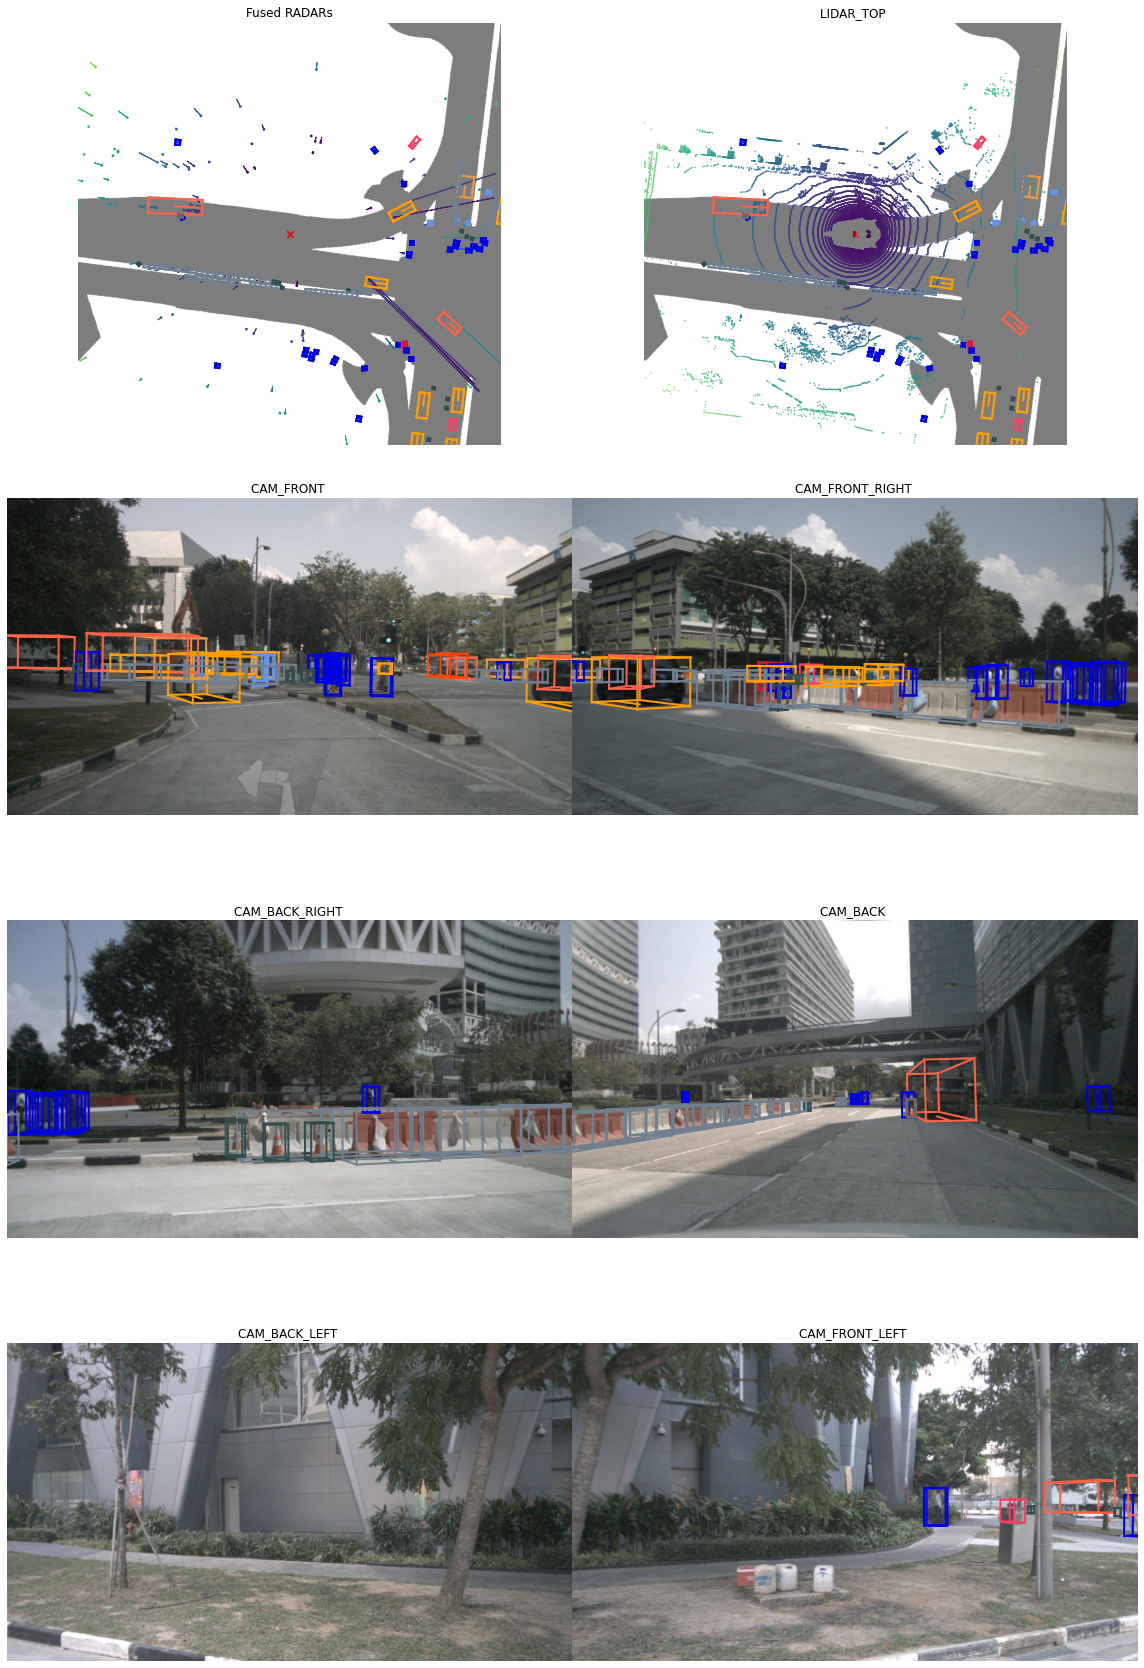

In [17]:
nusc.render_sample(first_sample_token)

In [18]:
# Bind to localhost:8888 (default)
# ! python plots/draw_webrtc.py
# # Bind to 127.0.0.1:8889
# ! WEBRTC_IP=127.0.0.1 WEBRTC_PORT=8889 python plots/draw_webrtc.py

INFO - 2022-03-27 13:30:18,607 - utils - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2022-03-27 13:30:18,608 - utils - NumExpr defaulting to 8 threads.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7fab3f843010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC HTTP server handshake mode enabled.
[Open3D INFO] Open3D WebVisualizer is serving at http://127.0.0.1:8889.
[Open3D INFO] Set WEBRTC_IP and WEBRTC_PORT environment variable to customize the HTTP server address.
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServ

In [ ]:
# import open3d as o3d
# from open3d.web_visualizer import draw


In [ ]:
# cube_red = o3d.geometry.TriangleMesh.create_box(1, 2, 4)
# cube_red.compute_vertex_normals()
# cube_red.paint_uniform_color((1.0, 0.0, 0.0))
# draw(cube_red)

In [ ]:
# draw(cube_red)

# cube_blue = o3d.geometry.TriangleMesh.create_box(1, 2, 4)
# cube_blue.compute_vertex_normals()
# cube_blue.paint_uniform_color((0.0, 0.0, 1.0))
# draw(cube_blue)
